In [1]:
from __future__ import print_function

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf
'''
from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()
'''
import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import seaborn as sns

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize

import h5py

#Visualization code

import matplotlib

def ic_scale(pwm,background):
    per_position_ic = util.compute_per_position_ic(
                       ppm=pwm, background=background, pseudocount=0.001)
    return pwm*(per_position_ic[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,**kwargs)
    plt.show()


def plot_score_track_given_ax(arr, ax, threshold=None, **kwargs):
    ax.plot(np.arange(len(arr)), arr, **kwargs)
    if (threshold is not None):
        ax.plot([0, len(arr)-1], [threshold, threshold])
    ax.set_xlim(0,len(arr)-1)

from matplotlib.ticker import FormatStrFormatter

def plot_score_track(arr, threshold=None, figsize=(20,2), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_score_track_given_ax(arr, threshold=threshold, ax=ax, **kwargs) 
    plt.show()

def plot_pwm(weights, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
    
    plot_funcs = {0: plot_a, 1: plot_c, 
                  2: plot_g, 3: plot_t}

    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(111) 
    
    plot_weights_given_ax(ax=ax, array=weights, 
                                       height_padding_factor=0.2,
                                       length_padding=1.0, 
                                       subticks_frequency=1.0, 
                                       colors=colors, plot_funcs=plot_funcs, 
                                       highlight={}, ylabel="")

    plt.sca(ax)
    
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    
    plt.tight_layout()
    
    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=600)
        plt.savefig(fig_name + ".eps")
    
    plt.show()

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def dna_letter_at(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange',#'orange', 
                    'A': 'green',#'red', 
                    'C': 'blue',#'blue', 
                    'T': 'red',#'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_seq_scores(importance_scores, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :

    importance_scores = importance_scores.T

    fig = plt.figure(figsize=figsize)
    
    ref_seq = ""
    for j in range(importance_scores.shape[1]) :
        argmax_nt = np.argmax(np.abs(importance_scores[:, j]))
        
        if argmax_nt == 0 :
            ref_seq += "A"
        elif argmax_nt == 1 :
            ref_seq += "C"
        elif argmax_nt == 2 :
            ref_seq += "G"
        elif argmax_nt == 3 :
            ref_seq += "T"

    ax = plt.gca()
    
    for i in range(0, len(ref_seq)) :
        mutability_score = np.sum(importance_scores[:, i])
        color = None
        dna_letter_at(ref_seq[i], i + 0.5, 0, mutability_score, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, len(ref_seq)))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            np.min(importance_scores) - 0.1 * np.max(np.abs(importance_scores)),
            np.max(importance_scores) + 0.1 * np.max(np.abs(importance_scores))
        )
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

def plot_pwm_2(pwm, figsize=(16, 2), plot_y_ticks=True, y_min=None, y_max=None, save_figs=False, fig_name="default") :
    
    fig = plt.figure(figsize=figsize)

    ax = plt.gca()
    
    height_base = 0.
    logo_height = 1.0
    
    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i]# * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if ii == 0 :
                dna_letter_at(nt, j + 0.5, height_base, nt_prob * logo_height, ax, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]]) * logo_height # * conservation[j]
                dna_letter_at(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax, color=color)
    
    plt.sca(ax)
    plt.xticks([], [])
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    plt.xlim((0, pwm.shape[0]))
    
    #plt.axis('off')
    
    if plot_y_ticks :
        plt.yticks(fontsize=12)
    else :
        plt.yticks([], [])
    
    if y_min is not None and y_max is not None :
        plt.ylim(y_min, y_max)
    elif y_min is not None :
        plt.ylim(y_min)
    else :
        plt.ylim(
            min(0., np.min(np.sum(pwm, axis=-1))) - 0.01 * np.max(np.abs(np.sum(pwm, axis=-1))),
            max(0., np.max(np.sum(pwm, axis=-1))) + 0.01 * np.max(np.abs(np.sum(pwm, axis=-1)))
        )
    
    print(np.min(np.sum(pwm, axis=-1)) - 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    print(np.max(np.sum(pwm, axis=-1)) + 0.1 * np.max(np.abs(np.sum(pwm, axis=-1))))
    
    plt.axhline(y=0., color='black', linestyle='-', linewidth=1)

    #for axis in fig.axes :
    #    axis.get_xaxis().set_visible(False)
    #    axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + ".png", transparent=True, dpi=300)
        plt.savefig(fig_name + ".eps")

    plt.show()

#One-hot-encoder
class SequenceEncoder :
    
    def __init__(self, encoder_type_id, encode_dims) :
        self.encoder_type_id = encoder_type_id
        self.encode_dims = encode_dims
    
    def encode(self, seq) :
        raise NotImplementedError()
    
    def encode_inplace(self, seq, encoding) :
        raise NotImplementedError()
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def decode(self, encoding) :
        raise NotImplementedError()
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementedError()
    
    def __call__(self, seq) :
        return self.encode(seq)
    
class OneHotEncoder(SequenceEncoder) :
    
    def __init__(self, seq_length, channel_map) :
        super(OneHotEncoder, self).__init__('onehot', (seq_length, len(channel_map)))
        
        self.seq_len = seq_length
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            val : key for key, val in channel_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            if max_nt == 1 :
                seq += self.decode_map[argmax_nt]
            else :
                seq += self.decode_map[self.n_channels - 1]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        encoding = np.array(encoding_mat[row_index, :].todense()).reshape(-1, 4)
        return self.decode(encoding)


Using TensorFlow backend.
2023-05-08 17:24:24.297462: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Load APARENT2 model

import os

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected2D, Conv1D, MaxPooling1D, LocallyConnected1D, LSTM, ConvLSTM2D, BatchNormalization
from keras.layers import Concatenate, Reshape
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='aparent_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=False)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=False)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_residual_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='aparent_skip_add')
    
    final_conv = Conv2D(1, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='aparent_final_conv')
    
    extend_tensor = Lambda(lambda x: K.concatenate([x[0], x[1][..., None, None]], axis=2), name='aparent_extend_tensor')
    
    expand_lib = Lambda(lambda x: K.tile(K.expand_dims(K.expand_dims(x, axis=1), axis=2), (1, 1, 206, 1)), name='aparent_expand_lib')
    
    lib_conv = LocallyConnected2D(1, (1, 1), strides=(1, 1), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='aparent_lib_conv')
    
    lib_add = Lambda(lambda x: x[0] + x[1], name='aparent_lib_add')
    
    def _net_func(sequence_input, lib_input, dummy_input) :
        conv_0_out = conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_out = extend_tensor([final_conv(skip_add_out), dummy_input])
        
        #Add library bias
        lib_conv_out = lib_add([final_conv_out, lib_conv(expand_lib(lib_input))])
        
        return lib_conv_out

    return _net_func

def get_kl_divergence() :
    
    def kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())

        return K.sum(y_true * K.log(y_true / y_pred), axis=-1)
    
    return kl_divergence

def get_sigmoid_kl_divergence() :
    
    def sigmoid_kl_divergence(inputs) :
        y_true, y_pred, counts = inputs
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        y_true = K.clip(y_true, K.epsilon(), 1. - K.epsilon())
        return K.sum(y_true * K.log(y_true / y_pred) + (1.0 - y_true) * K.log((1.0 - y_true) / (1.0 - y_pred)), axis=-1)
    
    return sigmoid_kl_divergence

def load_aparent_model() :
    
    #APARENT parameters
    seq_input_shape = (1, 205, 4)
    lib_input_shape = (13,)
    num_outputs_iso = 1
    num_outputs_cut = 206
    
    #Plasmid model definition
    
    #Resnet function
    resnet = load_residual_network(
        n_groups=7,
        n_resblocks_per_group=4,
        n_channels=32,
        window_size=3,
        dilation_rates=[1, 2, 4, 8, 4, 2, 1],
        drop_rate=0.0
    )

    #Inputs
    seq_input = Input(shape=seq_input_shape)
    lib_input = Input(shape=lib_input_shape)
    dummy_input = Input(shape=(1,))
    plasmid_count = Input(shape=(1,))

    #Outputs
    true_iso = Input(shape=(num_outputs_iso,))
    true_cut = Input(shape=(num_outputs_cut,))

    cut_score = resnet(seq_input, lib_input, dummy_input)

    cut_prob = Lambda(lambda x: K.softmax(x[:, 0, :, 0], axis=-1))(cut_score)
    iso_prob = Lambda(lambda cl: K.expand_dims(K.sum(cl[:, 80:80+30], axis=-1), axis=-1))(cut_prob)

    plasmid_model = Model(
        inputs=[
            seq_input,
            lib_input,
            dummy_input
        ],
        outputs=[
            iso_prob,
            cut_prob
        ]
    )

    #Loss model definition
    sigmoid_kl_divergence = get_sigmoid_kl_divergence()
    kl_divergence = get_kl_divergence()
    
    plasmid_loss_iso = Lambda(sigmoid_kl_divergence, output_shape = (1,))([true_iso, iso_prob, plasmid_count])
    plasmid_loss_cut = Lambda(kl_divergence, output_shape = (1,))([true_cut, cut_prob, plasmid_count])

    total_loss = Lambda(
        lambda l: 0.5 * l[0] + 0.5 * l[1],
        output_shape = (1,)
    )(
        [
            plasmid_loss_iso,
            plasmid_loss_cut
        ]
    )

    loss_model = Model([
        seq_input,
        lib_input,
        dummy_input,
        plasmid_count,
        true_iso,
        true_cut
    ], total_loss)

    return [ ('plasmid_iso_cut_resnet', plasmid_model), ('loss', loss_model) ]

#Make new model with scalar isoform logit output
proximal_start = 77
proximal_end = 127

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../Keratinocyte_samples')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_aparent_model()[0][1]
aparent_model.load_weights(model_path, by_name=True)

#Re-define model for total isoform attribution
seq_input = Input(name="seq_input", shape=(1, 205, 4))
l_input = Input(name="l_input", shape=(13,))
dummy_input = Input(name="dummy_input", shape=(1,))

seq_cut = aparent_model([seq_input, l_input, dummy_input])[1]

def _lor(cuts_ref, iso_start=proximal_start, iso_end=proximal_end) :

    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    
    lor = K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')(seq_cut)

aparent = Model(
    inputs=[seq_input, l_input, dummy_input],
    outputs=[lor_pred]
)

aparent.trainable = False

aparent.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2023-05-08 17:25:15.857609: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-05-08 17:25:15.996910: E tensorflow/stream_executor/cuda/cuda_driver.cc:322] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-08 17:25:15.996965: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (johannes-design-interpret-1): /proc/driver/nvidia/version does not exist
2023-05-08 17:25:16.006558: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2023-05-08 17:25:16.007991: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558b5eb68f40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-08 17:25:16.008025: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [3]:

df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")
x, m, l, c, y = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))


x.shape = (5267, 10, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 10, 28)
y.shape = (5267, 10, 28)


In [4]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores", s)
s = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores.npy")

print(s.shape)


(5267, 10)


In [5]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i:i+1, dist_index[i], :])

y_dist = np.concatenate(y_dist, axis=0)

print(y_dist.shape)


(5267, 28)


In [6]:
#Load tissue-specific PAS model and generate scores for select tissue types

subset_cell_types = np.array([
    'NT',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'FIP1L1',
    'NUDT21',
    'RBBP6',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

subset_cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(subset_cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [7]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [8]:
#PAS network definition

import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

def load_pas_network(n_cell_types=1, n_dil=6, n_channels=32, filter_size=3, filter_size_0=5, nonneg_up_to=0) :
    
    conv_0 = Conv2D(n_channels, kernel_size=(1, filter_size_0), kernel_constraint=keras.constraints.NonNeg() if nonneg_up_to > 0 else None, padding='same', activation='relu', name='pasnet_conv2d_0')
    
    drop_0 = Dropout(0.5, name='pasnet_drop_0')
    
    convs = [
        Conv2D(n_channels, kernel_size=(1, filter_size), kernel_constraint=keras.constraints.NonNeg() if i < nonneg_up_to else None, padding='same', activation='relu', dilation_rate=2**i, name='pasnet_conv2d_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    drops = [
        Dropout(0.5, name='pasnet_drop_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    adds = [
        Lambda(lambda x: x[0] + x[1], name='pasnet_add_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    pool = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types*3, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')
    final_reshape = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], n_cell_types, 3)))
    
    def _net_func(sequence_input) :
        
        x = drop_0(conv_0(sequence_input))

        for i in range(1, n_dil+1):
            x = adds[i-1]([drops[i-1](convs[i-1](x)), x])

        pool_out = pool(x)

        final_dense_out = final_dense(pool_out)
        
        return final_reshape(final_dense_out)

    return _net_func

def _load_pas_model(model_name, n_cell_types=1) :
    
    seq_input = Input(shape=(1, 205, 4), name='seq_input')
    
    pas_net = load_pas_network(n_cell_types=n_cell_types)
    
    pred_output = pas_net(seq_input)
    
    pas_model = Model(seq_input, pred_output)
    pas_model.load_weights(model_name, by_name=True)
    pas_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(0.1))
    
    return pas_model

def _predict_multi_pas(pas_model, x, batch_size=32) :
    
    y_preds = []
    for k in range(x.shape[1]) :
        y_preds.append(pas_model.predict(x=[x[:, k:k+1, ...]], batch_size=32)[:, None, ...])
    
    return np.concatenate(y_preds, axis=1)


In [9]:
#Model parameters

n_bootstraps = 5
n_cell_types = subset_cell_types.shape[0]


In [10]:
#Predict tissue model scores

tissue_models = [
    _load_pas_model("saved_models/perturb_resnet_utr3_covar_drop_ensemble_" + str(bootstrap_ix) + "_pas_model.h5", n_cell_types=n_cell_types) for bootstrap_ix in range(n_bootstraps)
]
'''
ts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)

ts = np.mean(ts_ensemble, axis=-1)

print("ts.shape = " + str(ts.shape))
'''

'\nts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)\n\nts = np.mean(ts_ensemble, axis=-1)\n\nprint("ts.shape = " + str(ts.shape))\n'

In [11]:
#Cache/Load tissue scores
'''
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble", ts_ensemble)
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts", ts)
'''
ts_ensemble = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble.npy")
ts = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts.npy")

print(ts_ensemble.shape)
print(ts.shape)


(5267, 10, 11, 3, 5)
(5267, 10, 11, 3)


In [12]:
#Compute normalization statistics

cell_type_ixs = [cell_type_dict[ct] for ct in subset_cell_types.tolist()]

flat_x = np.reshape(x, (x.shape[0] * x.shape[1], 1, 205, 4))
flat_ts_ensemble = np.reshape(ts_ensemble, (x.shape[0] * x.shape[1], n_cell_types, n_bootstraps, 3))
flat_ts = np.reshape(ts, (x.shape[0] * x.shape[1], n_cell_types, 3))
flat_s = np.reshape(s, (x.shape[0] * x.shape[1],))
flat_y = np.reshape(y[:, :, cell_type_ixs], (x.shape[0] * x.shape[1], n_cell_types))
flat_gene_ind = np.reshape(np.tile(np.arange(x.shape[0])[:, None], (1, x.shape[1])), (x.shape[0] * x.shape[1],))
flat_pas_ind = np.reshape(np.tile(np.arange(x.shape[1])[None, :], (x.shape[0], 1)), (x.shape[0] * x.shape[1],))

flat_m = np.reshape(m, (x.shape[0] * x.shape[1],))
flat_dist_mask = np.reshape(dist_mask, (x.shape[0] * x.shape[1],))

flat_keep_index = np.nonzero(flat_m >= 1)[0]

flat_x = flat_x[flat_keep_index, ...]
flat_ts_ensemble = flat_ts_ensemble[flat_keep_index, ...]
flat_ts = flat_ts[flat_keep_index, ...]
flat_s = flat_s[flat_keep_index, ...]
flat_y = flat_y[flat_keep_index, ...]
flat_gene_ind = flat_gene_ind[flat_keep_index, ...]
flat_pas_ind = flat_pas_ind[flat_keep_index, ...]

flat_m = flat_m[flat_keep_index, ...]
flat_dist_mask = flat_dist_mask[flat_keep_index, ...]


In [13]:
#Construct masks for proximal/middle/distal sites

flat_prox_mask = np.array((flat_pas_ind == 0), dtype=np.float32)
flat_middle_mask = 1. - flat_dist_mask - flat_prox_mask

flat_masks = [
    flat_prox_mask,
    flat_middle_mask,
    flat_dist_mask
]


In [14]:
#Load processed (flattened) PAS IDs from original dataframe

flat_ids = np.load("polyadb_features_pas_3_utr3_perturb_flat_ids.npy", allow_pickle=True)

#Compile and flatten gene names
flat_gene_names = []
for _, row in df.iterrows() :
    flat_gene_names.extend([row['gene'] for k in range(m.shape[1]) if row['pas_exists_' + str(k)] == 1])

flat_gene_names = np.array(flat_gene_names, dtype=object)


In [15]:
#Re-load gated importance scores

flat_scores = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores.npy")
flat_scores = np.tile(flat_scores, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]

print("flat_scores.shape = " + str(flat_scores.shape))

#Re-load gated importance scores (bootstrap replicates)

n_bootstraps_ism = 3

flat_scores_ensemble = []

for bootstrap_ix in range(n_bootstraps_ism) :
    flat_scores_curr = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores_bootstrap_" + str(bootstrap_ix) + ".npy")
    flat_scores_curr = np.tile(flat_scores_curr, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]
    
    flat_scores_ensemble.append(flat_scores_curr)
    
    print("(bootstrap_ix = " + str(bootstrap_ix) + ") flat_scores.shape = " + str(flat_scores_curr.shape))


flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 0) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 1) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 2) flat_scores.shape = (11, 3, 14764, 1, 205, 4)


In [16]:
#Merge proximal/middle/distal predictions and ISM scores

flat_ts_merged = np.zeros((flat_x.shape[0], n_cell_types))

flat_ts_merged[flat_prox_mask == 1., ...] = flat_ts[flat_prox_mask == 1., ..., 0]
flat_ts_merged[flat_middle_mask == 1., ...] = flat_ts[flat_middle_mask == 1., ..., 1]
flat_ts_merged[flat_dist_mask == 1., ...] = flat_ts[flat_dist_mask == 1., ..., 2]

flat_scores_merged = np.zeros((n_cell_types, flat_x.shape[0], 1, 205, 4))

flat_scores_merged[:, flat_prox_mask == 1., ...] = flat_scores[:, 0, flat_prox_mask == 1., ...]
flat_scores_merged[:, flat_middle_mask == 1., ...] = flat_scores[:, 1, flat_middle_mask == 1., ...]
flat_scores_merged[:, flat_dist_mask == 1., ...] = flat_scores[:, 2, flat_dist_mask == 1., ...]


In [17]:
#Calculate 'native' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.0)
s_qtl_hi = np.quantile(flat_s, q=1.0)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_native = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_native = " + str(np.round(mononuc_native, 2).tolist()))

#Calculate 'neutral' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.45)
s_qtl_hi = np.quantile(flat_s, q=0.55)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_neutral = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_neutral = " + str(np.round(mononuc_neutral, 2).tolist()))

#Calculate 'weak' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.0)
s_qtl_hi = np.quantile(flat_s, q=0.1)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_weak = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_weak = " + str(np.round(mononuc_weak, 2).tolist()))

#Calculate 'stong' background nucleotide frequencies
s_qtl_lo = np.quantile(flat_s, q=0.9)
s_qtl_hi = np.quantile(flat_s, q=1.0)

filter_index = np.nonzero((flat_s >= s_qtl_lo) & (flat_s < s_qtl_hi))[0]

#Calculate filtered mononucleotide background frequencies
mononuc_stong = np.sum(flat_x[filter_index, 0, 0:146, :], axis=(0, 1)) / np.sum(flat_x[filter_index, 0, 0:146, :])

print("mononuc_stong = " + str(np.round(mononuc_stong, 2).tolist()))


mononuc_native = [0.3, 0.17, 0.18, 0.35]
mononuc_neutral = [0.31, 0.17, 0.17, 0.35]
mononuc_weak = [0.28, 0.2, 0.21, 0.31]
mononuc_stong = [0.3, 0.15, 0.16, 0.39]


In [18]:
#Load module A/B proximal PAS IDs

n_sequences = 50

module_a_ids = pd.read_csv("moduleA_proximal_sites.txt", sep='\t', names=['pas_id'])['pas_id'].values.tolist()[:n_sequences]
module_b_ids = pd.read_csv("moduleB_proximal_sites.txt", sep='\t', names=['pas_id'])['pas_id'].values.tolist()[:n_sequences]

print("len(module_a_ids) = " + str(len(module_a_ids)))
print("len(module_b_ids) = " + str(len(module_b_ids)))


len(module_a_ids) = 50
len(module_b_ids) = 50


In [19]:
#Collect module A pas indices

a_index = []
for i, flat_id in enumerate(flat_ids.tolist()) :
    if flat_id in module_a_ids :
        a_index.append(i)

a_index = np.array(a_index, dtype='int32')

#Collect module B pas indices

b_index = []
for i, flat_id in enumerate(flat_ids.tolist()) :
    if flat_id in module_b_ids :
        b_index.append(i)

b_index = np.array(b_index, dtype='int32')

print("a_index.shape = " + str(a_index.shape))
print("b_index.shape = " + str(b_index.shape))

#Get module A gene and pas indices
gene_ind_a = flat_gene_ind[a_index]
pas_ind_a = flat_pas_ind[a_index]

#Get module B gene and pas indices
gene_ind_b = flat_gene_ind[b_index]
pas_ind_b = flat_pas_ind[b_index]


a_index.shape = (50,)
b_index.shape = (50,)


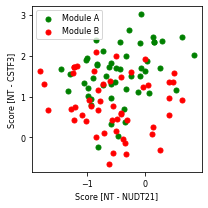

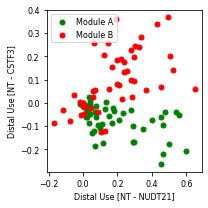

In [20]:
#Visualize predicted perturbation scores for WT module A/B sequences

#CSTF3 perturb scores
ts_a_cstf3 = flat_ts[a_index, 0, 0] - flat_ts[a_index, 4, 0]
ts_b_cstf3 = flat_ts[b_index, 0, 0] - flat_ts[b_index, 4, 0]

#NUDT21 perturb scores
ts_a_nudt21 = flat_ts[a_index, 0, 0] - flat_ts[a_index, 6, 0]
ts_b_nudt21 = flat_ts[b_index, 0, 0] - flat_ts[b_index, 6, 0]

f = plt.figure(figsize=(3, 3))

plt.scatter(ts_a_nudt21, ts_a_cstf3, color='green', s=25, label='Module A')
plt.scatter(ts_b_nudt21, ts_b_cstf3, color='red', s=25, label='Module B')

plt.xlabel("Score [NT - NUDT21]", fontsize=8)
plt.ylabel("Score [NT - CSTF3]", fontsize=8)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.show()

#Visualize measured distal perturbations for WT module A/B sequences

#CSTF3 perturb scores
y_diff_a_cstf3 = y_dist[gene_ind_a, cell_type_dict['NT']] - y_dist[gene_ind_a, cell_type_dict['CSTF3']]
y_diff_b_cstf3 = y_dist[gene_ind_b, cell_type_dict['NT']] - y_dist[gene_ind_b, cell_type_dict['CSTF3']]

#NUDT21 perturb scores
y_diff_a_nudt21 = y_dist[gene_ind_a, cell_type_dict['NT']] - y_dist[gene_ind_a, cell_type_dict['NUDT21']]
y_diff_b_nudt21 = y_dist[gene_ind_b, cell_type_dict['NT']] - y_dist[gene_ind_b, cell_type_dict['NUDT21']]

f = plt.figure(figsize=(3, 3))

plt.scatter(y_diff_a_nudt21, y_diff_a_cstf3, color='green', s=25, label='Module A')
plt.scatter(y_diff_b_nudt21, y_diff_b_cstf3, color='red', s=25, label='Module B')

plt.xlabel("Distal Use [NT - NUDT21]", fontsize=8)
plt.ylabel("Distal Use [NT - CSTF3]", fontsize=8)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.show()


In [74]:
#1: Optimally perturb Module A downstream regions to minimize CSTF3 perturbation

def _shuffle_seq(seq, ablate_regions, bg, n_samples=5, window_size=9) :
    
    nts = ['A', 'C', 'G', 'T']
    
    seqs_shuffled = []
    
    for [ablate_start, ablate_end] in ablate_regions :
        
        for sample_ix in range(n_samples) :
            rand_seq = "".join(np.random.choice(nts, size=(window_size,), p=bg, replace=True).tolist())
            ablated_seq = seq[:ablate_start] + rand_seq + seq[ablate_end:]

            seqs_shuffled.append(ablated_seq)

    return seqs_shuffled

cell_type_1_ix = 0
cell_type_2_ix = 4

score_ix = 0

window_size = 9

n_shuffles = 5

outlier_index = a_index.tolist()

pred_cell_type_2_ixs = [4, 6]

seq_start = 0
seq_end = 205

save_name = "module_A_or_B/module_A_shuffle_cell_type_1_ix_" + str(cell_type_1_ix) + "_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_window_size_" + str(window_size)
    
if not os.path.exists("./samples/" + save_name.split("/")[0]) :
    os.makedirs("./samples/" + save_name.split("/")[0])

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

flat_y_diff = flat_y[:, cell_type_2_ix] - flat_y[:, cell_type_1_ix]

#Uniform frequencies
bg_nuc = 0.25 * np.ones(4, dtype='float32')

#Save sequences to file
with open("./samples/" + save_name + ".txt", "w") as f :

    diff_score_col_str = ""
    for pred_cell_type_2_ix in pred_cell_type_2_ixs :
        for sc_ix in range(3) :
            diff_score_col_str += "\tdiff_ct_" + str(pred_cell_type_2_ix) + "_score_" + str(sc_ix)

    f.write("gene_id\tpas_id\texperiment\tseq\tusage_nt\tusage_perturb\tusage_diff" + diff_score_col_str + "\n")

    for i in outlier_index :
        gene_id = flat_gene_names[i]
        pas_id = flat_ids[i]
        experiment = 'wt'
        wt_seq = acgt_encoder.decode(flat_x[i, 0, seq_start:seq_end, :])
        
        print("Processing pas_id = '" + str(pas_id) + "'")

        y_curr_nt = round(flat_y[i, cell_type_1_ix], 4)
        y_curr_perturb = round(flat_y[i, cell_type_2_ix], 4)

        y_curr_diff = round(-flat_y_diff[i], 4)

        pred_curr = []
        for bootstrap_ix in range(n_bootstraps) :
            pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                flat_x[i:i+1, ...]
            ], batch_size=1, verbose=False))

        pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

        diff_score_str = ""
        for pred_cell_type_2_ix in pred_cell_type_2_ixs :
            for sc_ix in range(3) :
                diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

        #Store wildtype sequence
        f.write(gene_id + "\t" + pas_id + "\t" + experiment + "\t" + wt_seq + "\t" + str(y_curr_nt) + "\t" + str(y_curr_perturb) + "\t" + str(y_curr_diff) + diff_score_str + "\n")

        #Find downstream position of maximal CSTF3 perturbation effect
        argmax_pos = -1
        max_val = -np.inf
        
        for pos in range(76 + window_size // 2, 146 - window_size // 2) :
            
            #Shuffle sequence around position
            shuffled_seqs = _shuffle_seq(wt_seq, [[pos - window_size // 2, pos + window_size // 2 + 1]], bg_nuc, n_samples=32, window_size=window_size)
            
            #Score sequences and calculate mean effect to CSTF3 perturbation
            shuffled_vals = []
            for shuffled_seq in shuffled_seqs :
                pred_curr = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                        acgt_encoder.encode(shuffled_seq)[None, None, ...]
                    ], batch_size=1, verbose=False))

                pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)
                
                shuffled_vals.append(
                    - (pred_curr[cell_type_1_ix, score_ix] - pred_curr[cell_type_2_ix, score_ix])
                )
            
            mean_val = np.mean(np.array(shuffled_vals))
            
            if mean_val > max_val :
                argmax_pos = pos
                max_val = mean_val
        
        print(" - (max_pos = " + str(argmax_pos) + ")")
        print(" - (window = '" + str(wt_seq[argmax_pos - window_size // 2: argmax_pos + window_size // 2 + 1]) + "')")
        
        #Store shuffled sequences for max position        
        shuffled_seqs = _shuffle_seq(wt_seq, [[argmax_pos - window_size // 2, argmax_pos + window_size // 2 + 1]], bg_nuc, n_samples=n_shuffles, window_size=window_size)
        
        for shuffle_i in range(len(shuffled_seqs)) :
                
            shuffled_seq = shuffled_seqs[shuffle_i]

            flat_x_shuffled = acgt_encoder.encode(shuffled_seq)[None, None, ...]

            pred_curr = []
            for bootstrap_ix in range(n_bootstraps) :
                pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                    flat_x_shuffled
                ], batch_size=1, verbose=False))

            pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

            diff_score_str = ""
            for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                for sc_ix in range(3) :
                    diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

            #Store shuffled sequence
            f.write(gene_id + "\t" + pas_id + "\t" + "shuffle_pos_" + str(argmax_pos) + "_repeat" + str(shuffle_i) + "\t" + shuffled_seq + "\t" + str(0.) + "\t" + str(0.) + "\t" + str(0.) + diff_score_str + "\n")


Processing pas_id = 'chr1_150220378_-'
 - (max_pos = 108)
 - (window = 'TGGTGCATT')
Processing pas_id = 'chr1_161959062_+'
 - (max_pos = 108)
 - (window = 'ATGCATGTT')
Processing pas_id = 'chr1_175010264_+'
 - (max_pos = 108)
 - (window = 'TGGTTTTAT')
Processing pas_id = 'chr1_180111194_+'
 - (max_pos = 113)
 - (window = 'TTTCTGCCT')
Processing pas_id = 'chr1_100990063_-'
 - (max_pos = 109)
 - (window = 'TTTCTTCAT')
Processing pas_id = 'chr1_51355237_-'
 - (max_pos = 119)
 - (window = 'TGTTTTGTT')
Processing pas_id = 'chr1_40516035_+'
 - (max_pos = 110)
 - (window = 'TGGTTTTTT')
Processing pas_id = 'chr1_212895414_+'
 - (max_pos = 89)
 - (window = 'TTGAAAATT')
Processing pas_id = 'chr1_92246494_-'
 - (max_pos = 109)
 - (window = 'GATTCATTT')
Processing pas_id = 'chr1_1786755_-'
 - (max_pos = 106)
 - (window = 'TGTAATTGT')
Processing pas_id = 'chr1_52417021_+'
 - (max_pos = 117)
 - (window = 'TTTTGGTTT')
Processing pas_id = 'chr1_202880922_-'
 - (max_pos = 131)
 - (window = 'TTCTTGTCT')


len(df_wt) = 50
len(df_mut) = 50


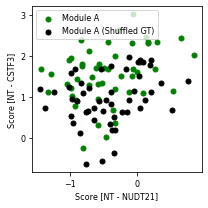

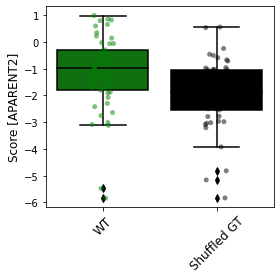

-- Top 10 5-mers shuffled in designs --
[('TTTTT', 13.0), ('TTTCT', 8.0), ('TGTTT', 7.0), ('GTTTT', 6.0), ('TTTGT', 5.0), ('TTTTA', 5.0), ('CTTTT', 5.0), ('TTCTT', 5.0), ('TTATT', 5.0), ('GGTTT', 4.0)]


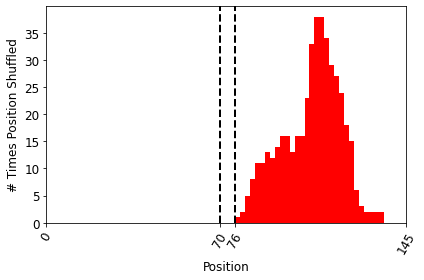

In [21]:
#Visualize module A designs

import seaborn as sns

cell_type_1_ix = 0
cell_type_2_ix = 4

score_ix = 0

window_size = 9

n_shuffles = 5

outlier_index = a_index.tolist()

pred_cell_type_2_ixs = [4, 6]

seq_start = 0
seq_end = 205

save_name = "module_A_or_B/module_A_shuffle_cell_type_1_ix_" + str(cell_type_1_ix) + "_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_window_size_" + str(window_size)

df = pd.read_csv("samples/" + save_name + ".txt", sep='\t')

#Get wt dataframe
df_wt = df.query("experiment == 'wt'").copy().reset_index(drop=True)

#Get non-wt dataframes
df_mut = df.query("experiment != 'wt'").copy().reset_index(drop=True)

#Augment with wt predictions
df_mut = df_mut.join(df_wt[[
    'pas_id',
    'seq',
    'diff_ct_4_score_0',
    'diff_ct_6_score_0',
]].set_index("pas_id"), on='pas_id', how='inner', rsuffix='_wt').copy().reset_index(drop=True)

#Predict with aparent2

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

x_wt = []
for _, row in df_wt.iterrows() :
    x_wt.append(
        acgt_encoder.encode(row['seq'])[None, None, ...]
    )
x_wt = np.concatenate(x_wt, axis=0)
l_wt = np.zeros((x_wt.shape[0], 13))
l_wt[:, 11] = 1.
d_wt = np.zeros((x_wt.shape[0], 1))
df_wt['aparent2_score'] = aparent.predict(x=[x_wt, l_wt, d_wt], batch_size=32)[:, 0]

x_mut = []
for _, row in df_mut.iterrows() :
    x_mut.append(
        acgt_encoder.encode(row['seq'])[None, None, ...]
    )
x_mut = np.concatenate(x_mut, axis=0)
l_mut = np.zeros((x_mut.shape[0], 13))
l_mut[:, 11] = 1.
d_mut = np.zeros((x_mut.shape[0], 1))
df_mut['aparent2_score'] = aparent.predict(x=[x_mut, l_mut, d_mut], batch_size=32)[:, 0]

#Aggregate over replicates
df_mut['superexperiment'] = df_mut['experiment'].apply(lambda x: x.split("_repeat")[0])
df_mut = df_mut.groupby(['pas_id', 'superexperiment']).agg({
    'gene_id' : 'first',
    'experiment' : 'first',
    'seq' : 'first',
    'seq_wt' : 'first',
    'aparent2_score' : 'mean',
    'diff_ct_4_score_0' : 'mean',
    'diff_ct_6_score_0' : 'mean',
    'diff_ct_4_score_0_wt' : 'mean',
    'diff_ct_6_score_0_wt' : 'mean',
}).copy().reset_index().reset_index(drop=True)

print("len(df_wt) = " + str(len(df_wt)))
print("len(df_mut) = " + str(len(df_mut)))

a_wt = np.array(df_wt['aparent2_score'].values)
a_mut = np.array(df_mut['aparent2_score'].values)

#CSTF3 perturb scores (wt)
ts_a_cstf3_wt = df_wt['diff_ct_4_score_0']

#CSTF3 perturb scores (mut)
ts_a_cstf3_mut = df_mut['diff_ct_4_score_0']

#NUDT21 perturb scores (wt)
ts_a_nudt21_wt = df_wt['diff_ct_6_score_0']

#NUDT21 perturb scores (mut)
ts_a_nudt21_mut = df_mut['diff_ct_6_score_0']

#Visualize shifted ditribution of CSTF3 scores
f = plt.figure(figsize=(3, 3))

plt.scatter(ts_a_nudt21_wt, ts_a_cstf3_wt, color='green', s=25, label='Module A')
plt.scatter(ts_a_nudt21_mut, ts_a_cstf3_mut, color='black', s=25, label='Module A (Shuffled GT)')

plt.xlabel("Score [NT - NUDT21]", fontsize=8)
plt.ylabel("Score [NT - CSTF3]", fontsize=8)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.show()

#Visualize shifted ditribution of aparent2 scores
f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[a_wt, a_mut], palette=['green', 'black'])
sns.stripplot(data=[a_wt, a_mut], palette=['green', 'black'], alpha=0.5)

plt.xticks([0, 1], ['WT', 'Shuffled GT'], fontsize=12, rotation=45)
plt.ylabel("Score [APARENT2]", fontsize=12)

plt.tight_layout()

plt.show()

#Extract k-mers
mer_len = 5
top_k_mers = 10

df_mut['shuffle_pos'] = df_mut['superexperiment'].apply(lambda x: int(x.split("_pos_")[1]))
df_mut['motif'] = df_mut.apply(lambda row, window_size=window_size: row['seq_wt'][row['shuffle_pos']-window_size//2:row['shuffle_pos']+window_size//2+1], axis=1)

mer_dict = {}
for _, row in df_mut.iterrows() :
    for j in range(window_size - mer_len + 1) :
        mer = row['motif'][j:j+mer_len]
        if mer not in mer_dict :
            mer_dict[mer] = 0.

        mer_dict[mer] += 1.

#Print top N k-mers
print("-- Top " + str(top_k_mers) + " " + str(mer_len) + "-mers shuffled in designs --")

sorted_mers = sorted(mer_dict.items(), key=lambda x:x[1])
print(sorted_mers[::-1][:top_k_mers])

#Plot histogram of motif shuffle positions
shuffle_poses = []
for _, row in df_mut.iterrows() :
    for j in range(row['shuffle_pos']-window_size//2, row['shuffle_pos']+window_size//2+1) :
        shuffle_poses.append(j)

shuffle_poses = np.array(shuffle_poses, dtype='float32')

f = plt.figure(figsize=(6, 4))

plt.hist(shuffle_poses, bins=146 // 2, range=(0, 146), color='red')

plt.axvline(x=70, linewidth=2, linestyle='--', color='black')
plt.axvline(x=76, linewidth=2, linestyle='--', color='black')

plt.xticks([0, 70, 76, 145], [0, 70, 76, 145], rotation=60, fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Position", fontsize=12)
plt.ylabel("# Times Position Shuffled", fontsize=12)

plt.xlim(0, 145)

plt.tight_layout()

plt.show()


In [76]:
#2: Optimally insert GT-rich motif in Module B downstream regions to maximize CSTF3 perturbation

def _insert_gt(seq, insert_regions, n_samples=5, window_size=9) :
    
    gt_motifs = [
        'TGTGTGTGT',
        'TGTGTGTCT',
        'TGTGTCTGT',
        'TGTCTGTGT',
        'TCTGTGTGT',
        'TGTGTTTTT',
        'TTGTGTTTT',
        'TTTGTGTTT',
        'TTTTGTGTT',
        'TTTTTGTGT',
        'TGTCTTTTT',
        'TTGTCTTTT',
        'TTTGTCTTT',
        'TTTTGTCTT',
        'TTTTTGTCT',
    ]
    
    seqs_inserted = []
    
    for [insert_start, insert_end] in insert_regions :
        
        for sample_ix in range(n_samples) :
            
            rand_seq = np.random.choice(gt_motifs)[:window_size]
            inserted_seq = seq[:insert_start] + rand_seq + seq[insert_end:]

            seqs_inserted.append(inserted_seq)

    return seqs_inserted

cell_type_1_ix = 0
cell_type_2_ix = 4

score_ix = 0

window_size = 9

n_shuffles = 5

outlier_index = b_index.tolist()

pred_cell_type_2_ixs = [4, 6]

seq_start = 0
seq_end = 205

save_name = "module_A_or_B/module_B_insert_cell_type_1_ix_" + str(cell_type_1_ix) + "_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_window_size_" + str(window_size)

if not os.path.exists("./samples/" + save_name.split("/")[0]) :
    os.makedirs("./samples/" + save_name.split("/")[0])

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

flat_y_diff = flat_y[:, cell_type_2_ix] - flat_y[:, cell_type_1_ix]

#Save sequences to file
with open("./samples/" + save_name + ".txt", "w") as f :

    diff_score_col_str = ""
    for pred_cell_type_2_ix in pred_cell_type_2_ixs :
        for sc_ix in range(3) :
            diff_score_col_str += "\tdiff_ct_" + str(pred_cell_type_2_ix) + "_score_" + str(sc_ix)

    f.write("gene_id\tpas_id\texperiment\tseq\tusage_nt\tusage_perturb\tusage_diff" + diff_score_col_str + "\n")

    for i in outlier_index :
        gene_id = flat_gene_names[i]
        pas_id = flat_ids[i]
        experiment = 'wt'
        wt_seq = acgt_encoder.decode(flat_x[i, 0, seq_start:seq_end, :])
        
        print("Processing pas_id = '" + str(pas_id) + "'")

        y_curr_nt = round(flat_y[i, cell_type_1_ix], 4)
        y_curr_perturb = round(flat_y[i, cell_type_2_ix], 4)

        y_curr_diff = round(-flat_y_diff[i], 4)

        pred_curr = []
        for bootstrap_ix in range(n_bootstraps) :
            pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                flat_x[i:i+1, ...]
            ], batch_size=1, verbose=False))

        pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

        diff_score_str = ""
        for pred_cell_type_2_ix in pred_cell_type_2_ixs :
            for sc_ix in range(3) :
                diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

        #Store wildtype sequence
        f.write(gene_id + "\t" + pas_id + "\t" + experiment + "\t" + wt_seq + "\t" + str(y_curr_nt) + "\t" + str(y_curr_perturb) + "\t" + str(y_curr_diff) + diff_score_str + "\n")

        #Find downstream position of maximal CSTF3 perturbation effect
        argmax_pos = -1
        max_val = -np.inf
        
        for pos in range(76 + window_size // 2, 146 - window_size // 2) :
            
            #Insert motif into sequence around position
            inserted_seqs = _insert_gt(wt_seq, [[pos - window_size // 2, pos + window_size // 2 + 1]], n_samples=5, window_size=window_size)
            
            #Score sequences and calculate mean effect to CSTF3 perturbation
            inserted_vals = []
            for inserted_seq in inserted_seqs :
                pred_curr = []
                for bootstrap_ix in range(n_bootstraps) :
                    pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                        acgt_encoder.encode(inserted_seq)[None, None, ...]
                    ], batch_size=1, verbose=False))

                pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)
                
                inserted_vals.append(
                    (pred_curr[cell_type_1_ix, score_ix] - pred_curr[cell_type_2_ix, score_ix])
                )
            
            mean_val = np.mean(np.array(inserted_vals))
            
            if mean_val > max_val :
                argmax_pos = pos
                max_val = mean_val
        
        print(" - (max_pos = " + str(argmax_pos) + ")")
        
        #Store inserted sequences for max position        
        inserted_seqs = _insert_gt(wt_seq, [[argmax_pos - window_size // 2, argmax_pos + window_size // 2 + 1]], n_samples=5, window_size=window_size)
        
        for insert_i in range(len(inserted_seqs)) :
                
            inserted_seq = inserted_seqs[insert_i]

            flat_x_inserted = acgt_encoder.encode(inserted_seq)[None, None, ...]

            pred_curr = []
            for bootstrap_ix in range(n_bootstraps) :
                pred_curr.append(tissue_models[bootstrap_ix].predict(x=[
                    flat_x_inserted
                ], batch_size=1, verbose=False))

            pred_curr = np.mean(np.concatenate(pred_curr, axis=0), axis=0)

            diff_score_str = ""
            for pred_cell_type_2_ix in pred_cell_type_2_ixs :
                for sc_ix in range(3) :
                    diff_score_str += "\t" + str(round(pred_curr[cell_type_1_ix, sc_ix] - pred_curr[pred_cell_type_2_ix, sc_ix], 4))

            #Store shuffled sequence
            f.write(gene_id + "\t" + pas_id + "\t" + "insert_pos_" + str(argmax_pos) + "_repeat" + str(insert_i) + "\t" + inserted_seq + "\t" + str(0.) + "\t" + str(0.) + "\t" + str(0.) + diff_score_str + "\n")


Processing pas_id = 'chr1_23505671_-'
 - (max_pos = 100)
Processing pas_id = 'chr1_46676568_-'
 - (max_pos = 101)
Processing pas_id = 'chr1_150647903_-'
 - (max_pos = 106)
Processing pas_id = 'chr1_150575962_-'
 - (max_pos = 113)
Processing pas_id = 'chr1_25832288_+'
 - (max_pos = 99)
Processing pas_id = 'chr1_153661422_+'
 - (max_pos = 103)
Processing pas_id = 'chr1_23967463_-'
 - (max_pos = 105)
Processing pas_id = 'chr10_60794239_+'
 - (max_pos = 104)
Processing pas_id = 'chr10_87051481_-'
 - (max_pos = 110)
Processing pas_id = 'chr11_839789_-'
 - (max_pos = 99)
Processing pas_id = 'chr12_125025544_+'
 - (max_pos = 105)
Processing pas_id = 'chr12_54241619_-'
 - (max_pos = 102)
Processing pas_id = 'chr12_107734013_-'
 - (max_pos = 103)
Processing pas_id = 'chr12_120095742_-'
 - (max_pos = 107)
Processing pas_id = 'chr12_118414995_+'
 - (max_pos = 101)
Processing pas_id = 'chr12_47968488_+'
 - (max_pos = 116)
Processing pas_id = 'chr12_93409882_-'
 - (max_pos = 109)
Processing pas_id 

len(df_wt) = 50
len(df_mut) = 50


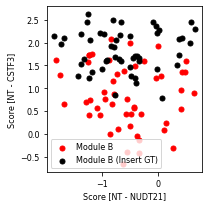

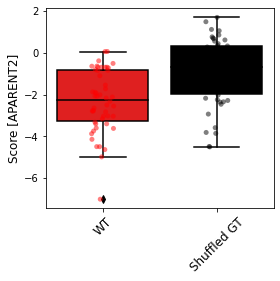

-- Top 10 5-mers inserted in designs --
[('TGTGT', 55.0), ('GTGTT', 19.0), ('TTGTG', 19.0), ('TTTGT', 18.0), ('TGTCT', 17.0), ('GTGTG', 16.0), ('TGTTT', 15.0), ('TTTTG', 13.0), ('TTTTT', 12.0), ('GTTTT', 11.0)]


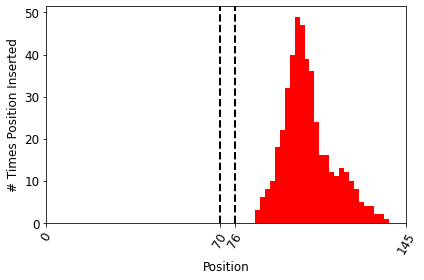

In [22]:
#Visualize module B designs

import seaborn as sns

cell_type_1_ix = 0
cell_type_2_ix = 4

score_ix = 0

window_size = 9

n_shuffles = 5

outlier_index = a_index.tolist()

pred_cell_type_2_ixs = [4, 6]

seq_start = 0
seq_end = 205

save_name = "module_A_or_B/module_B_insert_cell_type_1_ix_" + str(cell_type_1_ix) + "_cell_type_2_ix_" + str(cell_type_2_ix) + "_score_ix_" + str(score_ix) + "_n_sequences_" + str(n_sequences) + "_window_size_" + str(window_size)

df = pd.read_csv("samples/" + save_name + ".txt", sep='\t')

#Get wt dataframe
df_wt = df.query("experiment == 'wt'").copy().reset_index(drop=True)

#Get non-wt dataframes
df_mut = df.query("experiment != 'wt'").copy().reset_index(drop=True)

#Augment with wt predictions
df_mut = df_mut.join(df_wt[[
    'pas_id',
    'seq',
    'diff_ct_4_score_0',
    'diff_ct_6_score_0',
]].set_index("pas_id"), on='pas_id', how='inner', rsuffix='_wt').copy().reset_index(drop=True)

#Predict with aparent2

#Get sequence encoder
acgt_encoder = OneHotEncoder(205, {'A':0, 'C':1, 'G':2, 'T':3})

x_wt = []
for _, row in df_wt.iterrows() :
    x_wt.append(
        acgt_encoder.encode(row['seq'])[None, None, ...]
    )
x_wt = np.concatenate(x_wt, axis=0)
l_wt = np.zeros((x_wt.shape[0], 13))
l_wt[:, 11] = 1.
d_wt = np.zeros((x_wt.shape[0], 1))
df_wt['aparent2_score'] = aparent.predict(x=[x_wt, l_wt, d_wt], batch_size=32)[:, 0]

x_mut = []
for _, row in df_mut.iterrows() :
    x_mut.append(
        acgt_encoder.encode(row['seq'])[None, None, ...]
    )
x_mut = np.concatenate(x_mut, axis=0)
l_mut = np.zeros((x_mut.shape[0], 13))
l_mut[:, 11] = 1.
d_mut = np.zeros((x_mut.shape[0], 1))
df_mut['aparent2_score'] = aparent.predict(x=[x_mut, l_mut, d_mut], batch_size=32)[:, 0]

#Aggregate over replicates
df_mut['superexperiment'] = df_mut['experiment'].apply(lambda x: x.split("_repeat")[0])
df_mut = df_mut.groupby(['pas_id', 'superexperiment']).agg({
    'gene_id' : 'first',
    'experiment' : 'first',
    'seq' : 'first',
    'seq_wt' : 'first',
    'aparent2_score' : 'mean',
    'diff_ct_4_score_0' : 'mean',
    'diff_ct_6_score_0' : 'mean',
    'diff_ct_4_score_0_wt' : 'mean',
    'diff_ct_6_score_0_wt' : 'mean',
}).copy().reset_index().reset_index(drop=True)

print("len(df_wt) = " + str(len(df_wt)))
print("len(df_mut) = " + str(len(df_mut)))

a_wt = np.array(df_wt['aparent2_score'].values)
a_mut = np.array(df_mut['aparent2_score'].values)

#CSTF3 perturb scores (wt)
ts_a_cstf3_wt = df_wt['diff_ct_4_score_0']

#CSTF3 perturb scores (mut)
ts_a_cstf3_mut = df_mut['diff_ct_4_score_0']

#NUDT21 perturb scores (wt)
ts_a_nudt21_wt = df_wt['diff_ct_6_score_0']

#NUDT21 perturb scores (mut)
ts_a_nudt21_mut = df_mut['diff_ct_6_score_0']

#Visualize shifted ditribution of CSTF3 scores
f = plt.figure(figsize=(3, 3))

plt.scatter(ts_a_nudt21_wt, ts_a_cstf3_wt, color='red', s=25, label='Module B')
plt.scatter(ts_a_nudt21_mut, ts_a_cstf3_mut, color='black', s=25, label='Module B (Insert GT)')

plt.xlabel("Score [NT - NUDT21]", fontsize=8)
plt.ylabel("Score [NT - CSTF3]", fontsize=8)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.legend(fontsize=8)

plt.tight_layout()

plt.show()

#Visualize shifted ditribution of aparent2 scores
f = plt.figure(figsize=(4, 4))

sns.boxplot(data=[a_wt, a_mut], palette=['red', 'black'])
sns.stripplot(data=[a_wt, a_mut], palette=['red', 'black'], alpha=0.5)

plt.xticks([0, 1], ['WT', 'Shuffled GT'], fontsize=12, rotation=45)
plt.ylabel("Score [APARENT2]", fontsize=12)

plt.tight_layout()

plt.show()

#Extract k-mers
mer_len = 5
top_k_mers = 10

df_mut['shuffle_pos'] = df_mut['superexperiment'].apply(lambda x: int(x.split("_pos_")[1]))
df_mut['motif'] = df_mut.apply(lambda row, window_size=window_size: row['seq'][row['shuffle_pos']-window_size//2:row['shuffle_pos']+window_size//2+1], axis=1)

mer_dict = {}
for _, row in df_mut.iterrows() :
    for j in range(window_size - mer_len + 1) :
        mer = row['motif'][j:j+mer_len]
        if mer not in mer_dict :
            mer_dict[mer] = 0.

        mer_dict[mer] += 1.

#Print top N k-mers
print("-- Top " + str(top_k_mers) + " " + str(mer_len) + "-mers inserted in designs --")

sorted_mers = sorted(mer_dict.items(), key=lambda x:x[1])
print(sorted_mers[::-1][:top_k_mers])

#Plot histogram of motif shuffle positions
shuffle_poses = []
for _, row in df_mut.iterrows() :
    for j in range(row['shuffle_pos']-window_size//2, row['shuffle_pos']+window_size//2+1) :
        shuffle_poses.append(j)

shuffle_poses = np.array(shuffle_poses, dtype='float32')

f = plt.figure(figsize=(6, 4))

plt.hist(shuffle_poses, bins=146 // 2, range=(0, 146), color='red')

plt.axvline(x=70, linewidth=2, linestyle='--', color='black')
plt.axvline(x=76, linewidth=2, linestyle='--', color='black')

plt.xticks([0, 70, 76, 145], [0, 70, 76, 145], rotation=60, fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Position", fontsize=12)
plt.ylabel("# Times Position Inserted", fontsize=12)

plt.xlim(0, 145)

plt.tight_layout()

plt.show()
